In [3]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import laser_hockey_env_copy as lh
from importlib import reload
import gymnasium as gym
# import gym
from pyglet.window import key
import time

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda', index=0)

# Playground

In [4]:
reload(lh)
env = lh.LaserHockeyEnv()

c:\ProgramData\Anaconda3\envs\gymnasium_py3.11\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment LaserHockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [6]:
# torch.save(agent.state_dict(), 'agents/agent')

In [7]:
agent = lh.QNetwork(device)

In [8]:
agent.load_state_dict(torch.load('agents/agent1'))

<All keys matched successfully>

In [7]:
player1 = lh.HumanOpponent(env=env, player=1)
# player1 = lh.BasicOpponent()
player2 = lh.HumanOpponent(env=env, player=2)
# player2 = lh.BasicOpponent()
env.close()

In [11]:
env = lh.LaserHockeyEnv()
for i_episode in range(5):
# run = True
# while run:
    # env.reset()
    obs = env.reset()
    obs_agent2 = env.obs_agent_two()
    env.render()
    
    @env.viewer.window.event
    def on_key_press(symbol, modifiers):
        env.key_press(symbol, modifiers)
        if isinstance(player1, lh.HumanOpponent): player1.key_press(symbol, modifiers)
        if isinstance(player2, lh.HumanOpponent): player2.key_press(symbol, modifiers)

    @env.viewer.window.event
    def on_key_release(symbol, modifiers):
        if isinstance(player1, lh.HumanOpponent): player1.key_release(symbol, modifiers)
        if isinstance(player2, lh.HumanOpponent): player2.key_release(symbol, modifiers)

    time.sleep(.1)
    for _ in range(10000):
        a1 = player1.act(obs)
        # a1 = player1.act(obs, rnd=True)
        # a1 = agent(obs, device).detach().cpu().numpy()
        a2 = player2.act(obs_agent2)
        # a2 = agent(obs_agent2).detach().cpu().numpy()
        obs, r, d, info, _ = env.step(np.hstack([a1,a2]))    
        obs_agent2 = env.obs_agent_two()
        env.render()
        if d: break
env.close()

In [130]:
env.close()

# Without rendering

In [11]:
lh.RECORDING = False

In [12]:
lh.RECORDING

False

In [13]:
device = torch.device('cpu')
agent.to(device)

player1 = lh.BasicOpponent()
player2 = lh.BasicOpponent()

if lh.RECORDING:
    Data1 = lh.Data()
#     Data2 = lh.Data()

GAMES = 0
PLAYER1_WINS = 0
PLAYER2_WINS = 0
MAX_WINS = 100
    
while min(PLAYER1_WINS, PLAYER2_WINS) < MAX_WINS:
    GAMES += 1
    if lh.RECORDING:
        Data1.delete_temp()
        # Data2.delete_temp()
    obs = env.reset()
    obs_agent2 = env.obs_agent_two()
    for _ in range(300):
        # a1 = player1.act(obs, rnd=True)
        a1 = agent(obs, device).detach().cpu().numpy()
        a2 = player2.act(obs_agent2)
        # a2 = agent(obs_agent2, device).detach().cpu().numpy()
        if lh.RECORDING:
            Data1.obs_temp.append(obs)
            Data1.a_temp.append(a1)
            # Data2.obs_temp.append(obs_agent2)
            # Data2.a_temp.append(a2)
        obs, reward, done, info = env.step(np.hstack([a1,a2]))    
        obs_agent2 = env.obs_agent_two()
        # if ((_+1 == 300) and (not done)):
        #     if lh.RECORDING:
        #         Data1.obs_all.extend(Data1.obs_temp)
        #         Data1.a_all.extend(Data1.a_temp)
        #         Data1.r_all.extend(Data1.r_calculate(_+1))
                # Data2.obs_all.extend(Data2.obs_temp)
                # Data2.a_all.extend(Data2.a_temp)
                # Data2.r_all.extend(Data2.r_calculate(_+1))
        if done:
            if info['winner'] == 1:
                PLAYER1_WINS += 1
                if lh.RECORDING and PLAYER1_WINS < MAX_WINS:
                    Data1.obs_all.extend(Data1.obs_temp)
                    Data1.a_all.extend(Data1.a_temp)
                    Data1.r_all.extend(Data1.r_calculate(_+1, win=True))
                    # Data2.obs_all.extend(Data2.obs_temp)
                    # Data2.a_all.extend(Data2.a_temp)
                    # Data2.r_all.extend(Data2.r_calculate(_+1, win=False))
            elif info['winner'] == -1:
                PLAYER2_WINS += 1
                if lh.RECORDING and PLAYER2_WINS < MAX_WINS:
                    # Data2.obs_all.extend(Data2.obs_temp)
                    # Data2.a_all.extend(Data2.a_temp)
                    # Data2.r_all.extend(Data2.r_calculate(_+1, win=True))
                    Data1.obs_all.extend(Data1.obs_temp)
                    Data1.a_all.extend(Data1.a_temp)
                    Data1.r_all.extend(Data1.r_calculate(_+1, win=False))
            print(f'Game: {GAMES}      Player 1   {PLAYER1_WINS}/{PLAYER2_WINS}   Player 2', end='\r')
            break

device = torch.device('cuda:0')
agent.to(device)

# np.save('Data/obs3', Data1.obs_all_np())
# np.save('Data/a3', Data1.a_all_np())
# np.save('Data/r3', Data1.r_all_np())

KeyboardInterrupt: 

In [24]:
ENVS = 1024
MAX_WINS = 100
MAX_STEPS = 300

step_counter = np.zeros(ENVS, dtype=int)
PLAYER1_WINS, PLAYER2_WINS, GAMES = 0, 0, 0
envs, data, obs, obs2 = [], [], [], []
if lh.RECORDING: Data2 = lh.Data()

for _ in range(ENVS):
    print(f'Generating Environment: {_+1}/{ENVS}', end='\r')
    envs.append(lh.LaserHockeyEnv())
    # if _%2 == 0: envs[_].reset()
    envs[_].reset()
    obs.append(envs[_].reset())
    obs2.append(envs[_].obs_agent_two())
    if lh.RECORDING: data.append(lh.Data())

while min(PLAYER1_WINS, PLAYER2_WINS) < MAX_WINS:
    if GAMES == 0: print(f'Step: {step_counter[0]}{"":<50}', end='\r')
    # a1 = player1.act(obs, rnd=True)
    a1 = agent(obs).detach().cpu().numpy()
    a2 = player2.act(obs2)
    # a2 = agent(obs2).detach().cpu().numpy()
    if lh.RECORDING:
        for _ in range(ENVS):
            data[_].obs_temp.append(obs[_])
            data[_].a_temp.append(a1[_])
    obs, obs2, done = [], [], []
    for _ in range(ENVS):
        step_counter[_] += 1
        o, r, d, info = envs[_].step(np.hstack([a1[_], a2[_]]))
        obs.append(o)
        obs2.append(envs[_].obs_agent_two())
        done.append(d)
        if d:
            GAMES += 1
            if info['winner'] == 1:
                PLAYER1_WINS += 1
                if lh.RECORDING and PLAYER1_WINS < MAX_WINS:
                    Data2.obs_all.extend(data[_].obs_temp)
                    Data2.a_all.extend(data[_].a_temp)
                    Data2.r_all.extend(data[_].r_calculate(step_counter[_], win=True))
            elif info['winner'] == -1:
                PLAYER2_WINS += 1
                # if lh.RECORDING and PLAYER2_WINS < MAX_WINS:
                #     Data2.obs_all.extend(data[_].obs_temp)
                #     Data2.a_all.extend(data[_].a_temp)
                #     Data2.r_all.extend(data[_].r_calculate(step_counter[_], win=False))
            print(f'Game: {GAMES}      Player 1   {PLAYER1_WINS}/{PLAYER2_WINS}   Player 2', end='\r')
            if lh.RECORDING: data[_].delete_temp()
            envs[_].reset()
            obs[_] = envs[_].reset()
            obs2[_] = envs[_].obs_agent_two()
            step_counter[_] = 0
        if step_counter[_] == MAX_STEPS:
            GAMES += 1
            if lh.RECORDING: data[_].delete_temp()
            envs[_].reset()
            obs[_] = envs[_].reset()
            obs2[_] = envs[_].obs_agent_two()
            step_counter[_] = 0
            print(f'Game: {GAMES}      Player 1   {PLAYER1_WINS}/{PLAYER2_WINS}   Player 2', end='\r')

# np.save('Data/att_obs_0', Data2.obs_all_np())
# np.save('Data/att_a_0', Data2.a_all_np())
# np.save('Data/att_r_0', Data2.r_all_np())

# Recordings

In [32]:
# np.save('Data/obs_3.2', Data1.obs_all)
# np.save('Data/a_3.2', Data1.a_all)
# np.save('Data/a_i_2', Data1.a_all_index)
# np.save('Data/a_o_2', Data1.a_all_onehot)
# np.save('Data/r_3.2', Data1.r_all)
# np.save('Data/obs3', np.append(Data1.obs_all_np(), Data2.obs_all_np(), axis=0))
# np.save('Data/a3', np.append(Data1.a_all_np(), Data2.a_all_np(), axis=0))
# np.save('Data/r3', np.append(Data1.r_all_np(), Data2.r_all_np(), axis=0))

In [33]:
Data1, Data2 = lh.Data(), lh.Data()

In [34]:
Data1.obs_all = np.load('Data/obs_2.npy')
Data1.a_all = np.load('Data/a_2.npy')
Data1.a_all_index = np.load('Data/a_i_2.npy')
Data1.a_all_onehot = np.load('Data/a_o_2.npy')
Data1.r_all = np.load('Data/r_2.npy')
# Data2.obs_all = np.load('Data/obs3.2.npy')
# Data2.a_all = np.load('Data/a3.2.npy')
# Data2.r_all = np.load('Data/r3.2.npy')

In [35]:
print(np.shape(Data1.obs_all_np()))
print(np.shape(Data1.a_all_np()))
print(np.shape(Data1.a_all_index_np()))
print(np.shape(Data1.a_all_onehot_np()))
print(np.shape(Data1.r_all_np()))

(2728635, 16)
(2728635, 3)
(2728635, 3)
(2728635, 9)
(2728635, 1)


In [36]:
print(np.shape(Data2.obs_all_np()))
print(np.shape(Data2.a_all_np()))
print(np.shape(Data2.a_all_index_np()))
print(np.shape(Data2.a_all_onehot_np()))
print(np.shape(Data2.r_all_np()))

(0,)
(0,)
(0,)
(0,)
(0,)


In [37]:
all_obs_tensor = torch.tensor(Data1.obs_all_np(), dtype=torch.float, device=device)
all_a_tensor = torch.tensor(Data1.a_all_np(), dtype=torch.float, device=device)
all_a_tensor_index = torch.tensor(Data1.a_all_index_np(), dtype=torch.int64, device=device)
all_a_tensor_onehot = torch.tensor(Data1.a_all_onehot_np(), dtype=torch.float, device=device)
all_r_tensor = torch.tensor(Data1.r_all_np(), dtype=torch.float, device=device)
all_r_tensor_3x = torch.hstack((all_r_tensor, all_r_tensor, all_r_tensor))

In [ ]:
all_obs_tensor = torch.tensor(np.append(Data1.obs_all_np(), Data2.obs_all_np(), axis=0), dtype=torch.float, device=device)
all_a_tensor = torch.tensor(np.append(Data1.a_all_np(), Data2.a_all_np(), axis=0), dtype=torch.float, device=device)
all_a_tensor_index = torch.tensor(np.append(Data1.a_all_index_np(), Data2.a_all_index_np(), axis=0), dtype=torch.int64, device=device)
all_a_tensor_onehot = torch.tensor(np.append(Data1.a_all_onehot_np(), Data2.a_all_onehot_np(), axis=0), dtype=torch.float, device=device)
all_r_tensor = torch.tensor(np.append(Data1.r_all_np(), Data2.r_all_np(), axis=0), dtype=torch.float, device=device)
all_r_tensor_3x = torch.hstack((all_r_tensor, all_r_tensor, all_r_tensor))

In [39]:
print(all_obs_tensor.size())
print(all_a_tensor.size())
print(all_a_tensor_index.size())
print(all_a_tensor_onehot.size())
print(all_r_tensor.size())

torch.Size([2728635, 16])
torch.Size([2728635, 3])
torch.Size([2728635, 3])
torch.Size([2728635, 9])
torch.Size([2728635, 1])


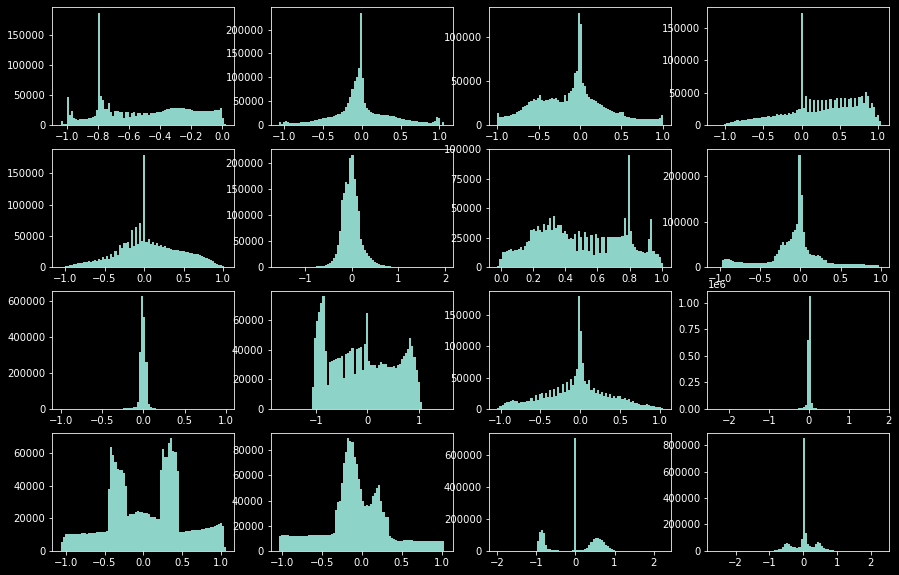

In [22]:
plt.figure(figsize=(15,10))

for _ in range(16):
    plt.subplot(4, 4, _+1)
    plt.hist(Data1.obs_all_np()[:,_], bins=80)
    # plt.hist(Data2.obs_all_np()[:,_], bins=80)

plt.show()

#     player 1                    x       y        a        v_x
#     player 1 / player 2         v_y     v_a      x        y
#     player 2                    a       v_x      v_y      v_a
#     puck                        x       y        v_x      v_y

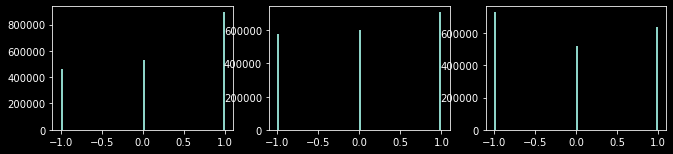

In [24]:
plt.figure(figsize=(11,5))

for _ in range(3):
    plt.subplot(2, 3, _+1)
    plt.hist(Data1.a_all_np()[:,_], bins=80)
    # plt.hist(Data1.a_all_onehot_np()[:,0,_], bins=80)
# for _ in range(3):
#     plt.subplot(2, 3, _+4)
#     plt.hist(Data2.a_all_np()[:,_], bins=80)

plt.show()

#    player 1          x        y        a
#    player 2          x        y        a

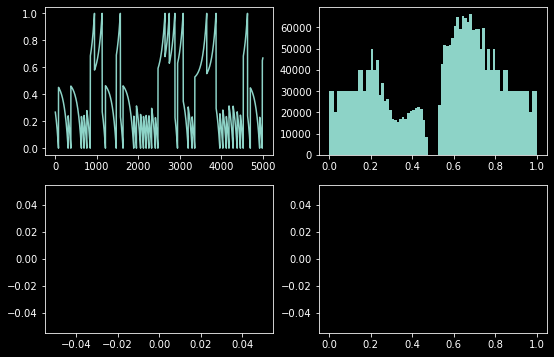

In [38]:
plt.figure(figsize=(9,6))

plt.subplot(2, 2, 1)
plt.plot(Data1.r_all_np()[540000:545000])
plt.subplot(2, 2, 2)
plt.hist(Data1.r_all_np(), bins=80)
plt.subplot(2, 2, 3)
plt.plot(Data2.r_all_np()[20000:40000])
plt.subplot(2, 2, 4)
plt.hist(Data2.r_all_np(), bins=80)

plt.show()

#    player 1          r        r
#    player 2          r        r

# Predictions

In [81]:
reload(lh)
env = lh.LaserHockeyEnv()

In [131]:
agent = lh.QNetwork(device)

In [66]:
critic = lh.CriticNetwork(device)

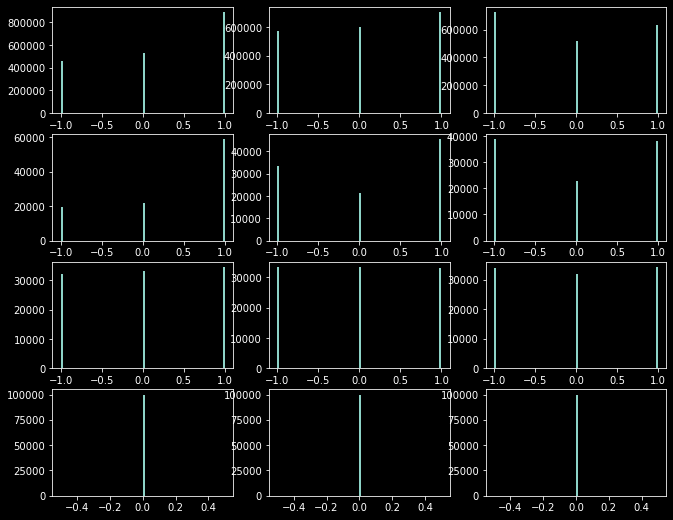

In [40]:
plt.figure(figsize=(11,9))

for _ in range(3):
    plt.subplot(4, 3, _+1)
    plt.hist(all_a_tensor.detach().cpu().numpy()[:,_], bins=80)
for _ in range(3):
    plt.subplot(4, 3, _+4)
    plt.hist(agent(all_obs_tensor[:100000], device, stochastic=False).detach().cpu().numpy()[:,_], bins=80)
for _ in range(3):
    plt.subplot(4, 3, _+7)
    plt.hist(agent(all_obs_tensor[:100000], device, stochastic=True).detach().cpu().numpy()[:,_], bins=80)
for _ in range(3):
    plt.subplot(4, 3, _+10)
    plt.hist(torch.abs(agent(all_obs_tensor[:100000], device) - all_a_tensor[:100000]).detach().cpu().numpy()[:,_], bins=80)

plt.show()

#    player 1          x        y        a
#    agent             x        y        a
#    loss              x        y        a

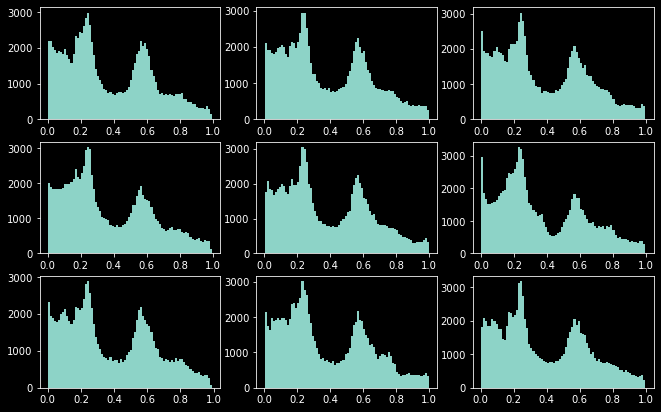

In [169]:
plt.figure(figsize=(11,7))

for _ in range(9):
    plt.subplot(3, 3, _+1)
    plt.hist(agent(all_obs_tensor[700000:800000], device, inside=True)[:,_].detach().cpu().numpy(), bins=80)

plt.show()

#    player 1          x        y        a
#    agent             x        y        a
#    loss              x        y        a

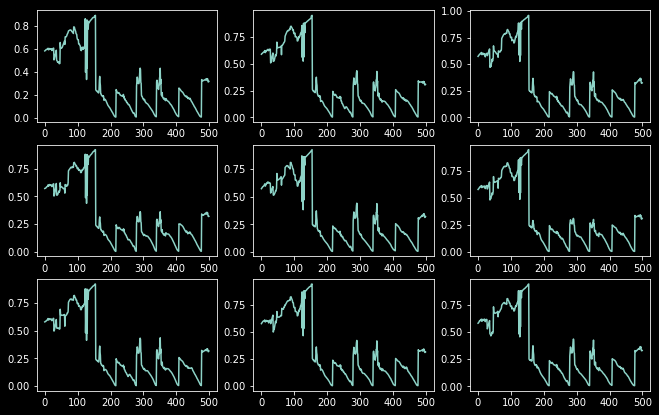

In [170]:
plt.figure(figsize=(11,7))

for _ in range(9):
    plt.subplot(3, 3, _+1)
    plt.plot(agent(all_obs_tensor[700000:800000], device, inside=True)[:500,_].detach().cpu().numpy())

plt.show()

#      q_x            -x        0        +x
#      q_y            -y        0        +y
#      q_a            -a        0        +a

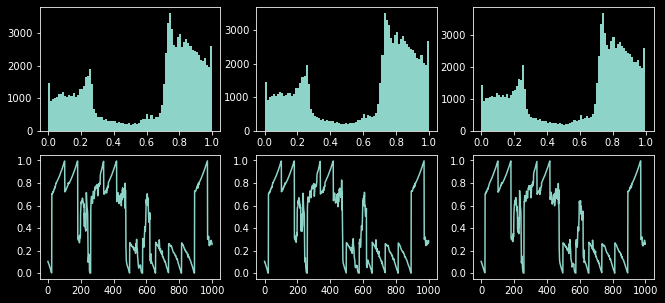

In [99]:
plt.figure(figsize=(11,5))

for _ in range(3):
    plt.subplot(2, 3, _+1)
    plt.hist(agent(all_obs_tensor[700000:800000], device, rl=True, action=all_a_tensor_index[700000:800000])[:,_].detach().cpu().numpy(), bins=80)
for _ in range(3):
    plt.subplot(2, 3, _+4)
    plt.plot(agent(all_obs_tensor[700000:800000], device, rl=True, action=all_a_tensor_index[700000:800000])[:1000,_].detach().cpu().numpy())

plt.show()

#    q             x        y        a
#    q             x        y        a

In [ ]:
plt.figure(figsize=(11,5))

plt.subplot(2, 3, 1)
plt.hist(all_r_tensor.detach().cpu().numpy(), bins=80)
plt.subplot(2, 3, 2)
plt.hist(critic(all_obs_tensor, device).detach().cpu().numpy(), bins=80)
plt.subplot(2, 3, 3)
plt.hist(torch.abs(critic(all_obs_tensor, device) - all_r_tensor).detach().cpu().numpy(), bins=80)
plt.subplot(2, 3, 4)
plt.plot(all_r_tensor.detach().cpu().numpy()[:1000])
plt.subplot(2, 3, 5)
plt.plot(critic(all_obs_tensor, device).detach().cpu().numpy()[:1000])

plt.show()

#    player 1          x        y        a
#    agent             x        y        a
#    loss              x        y        a

# Training

## QNetwork

In [ ]:
# Grid search
# 1. How much data
# 2. How many steps
# 3. Batch Size
# 4. Learning Rate

# Plot Loss curves
# Plot performance

In [40]:
reload(lh)
env = lh.LaserHockeyEnv()

In [299]:
agent = lh.QNetwork(device)

In [300]:
BATCH_SIZE = 4096
loss_fn = nn.L1Loss()
t = int(all_r_tensor.size()[0]*0.8)
dataset = TensorDataset(all_obs_tensor[:t], all_a_tensor_index[:t], all_r_tensor_3x[:t])
dataset_val = TensorDataset(all_obs_tensor[t+1:-1], all_a_tensor_index[t+1:-1], all_r_tensor_3x[t+1:-1])
dataloader, dataloader_temp = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True), iter(dataloader)
dataloader_val, dataloader_val_temp = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True), iter(dataloader_val)
steps = int(len(dataloader)*1)
optimizer = torch.optim.AdamW(agent.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=3e-2, total_steps=steps)

In [301]:
train_loss, val_loss = [], []

In [302]:
for _ in range(steps):
    if (_+1) % len(dataloader) == 0: dataloader_temp = iter(dataloader)
    obs, a, r = next(dataloader_temp)
    loss = loss_fn(agent(obs, rl=True, action=a), r)
    with torch.no_grad():
        if (_+1) % len(dataloader_val) == 0: dataloader_val_temp = iter(dataloader_val)
        obs, a, r = next(dataloader_val_temp)
        loss_val = loss_fn(agent(obs, rl=True, action=a), r)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    train_loss.append(loss.detach().cpu().numpy())
    val_loss.append(loss_val.detach().cpu().numpy())
    print(f'Step: {_+1}/{steps}   Loss: {loss.item()}', end='\r')

0.100449726


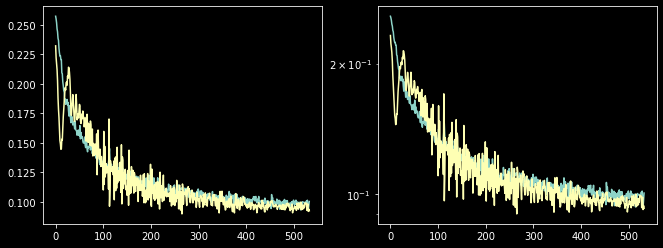

In [303]:
print(train_loss[-1])
plt.figure(figsize=(11,4))
plt.subplot(1, 2, 1)
plt.plot(train_loss[0:])
plt.plot(val_loss[0:])
plt.subplot(1, 2, 2)
plt.plot(train_loss[0:])
plt.plot(val_loss[0:])
plt.semilogy()
plt.show()

In [171]:
dict = {}
for n, p in enumerate(agent.parameters()):
    dict[n] = p.data.detach().cpu().numpy()

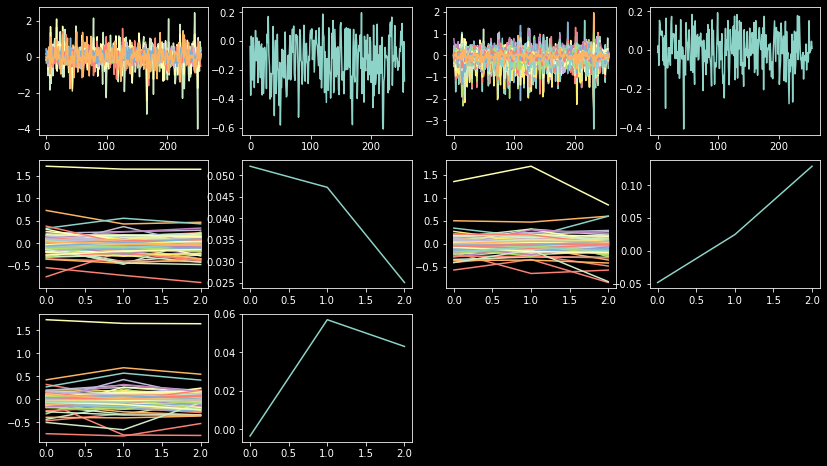

In [172]:
plt.figure(figsize=(14,8))

for _ in range(10):
    plt.subplot(3, 4, _+1)
    plt.plot(dict[_])

plt.show()

## Critic

In [394]:
reload(lh)
env = lh.LaserHockeyEnv()

In [131]:
critic = lh.CriticNetwork(device)

In [112]:
train_loss = []

In [113]:
BATCH_SIZE = 8192
epochs = [600, 100, 50, 50]
learning_rates= [3e-2, 1e-2, 3e-3, 1e-3]
loss_fn = nn.L1Loss()

dataset = TensorDataset(all_obs_tensor, all_r_tensor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
for _ in range(len(epochs)):
    optimizer = torch.optim.Adam(critic.parameters(), lr=learning_rates[_])
    for epoch in range(epochs[_]):
        for batch, (obs, r) in enumerate(dataloader):
            predictions = critic(obs, device)
            loss = loss_fn(predictions, r)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
            print(f'Epoch: {epoch+1}/{epochs[_]}/{_+1}   Loss: {loss.item()}   Batch: {batch+1}/{len(dataloader)}      ', end='\r')

In [ ]:
print(train_loss[-1])
plt.figure(figsize=(11,4))

plt.subplot(1, 2, 1)
plt.plot(train_loss[5:])
plt.subplot(1, 2, 2)
plt.plot(train_loss[0:])
plt.semilogy()

plt.show()

## Imitation

In [103]:
reload(lh)
env = lh.LaserHockeyEnv()

In [108]:
agent = lh.PolicyNetwork(device)

In [97]:
agent = lh.QNetwork(device)

In [109]:
BATCH_SIZE = 4096
epochs = [100, 50, 25, 25]
learning_rates= [3e-2, 1e-2, 3e-3, 3e-3]
loss_fn = nn.BCEWithLogitsLoss()

dataset = TensorDataset(all_obs_tensor, all_a_tensor_onehot)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [110]:
train_loss = []

In [111]:
for _ in range(len(epochs)):
    optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rates[_])
    for epoch in range(epochs[_]):
        for batch, (obs, a) in enumerate(dataloader):
            predictions = agent(obs, device, imitation=True)
            loss = loss_fn(predictions, a)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
            print(f'Epoch: {epoch+1}   Loss: {loss.item()}   Batch: {batch+1}', end = '\r')

0.087055564


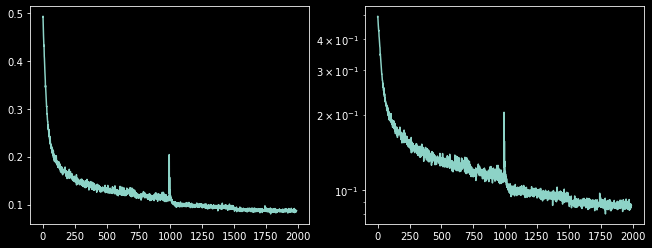

In [112]:
print(train_loss[-1])
plt.figure(figsize=(11,4))

plt.subplot(1, 2, 1)
plt.plot(train_loss[10:])
plt.subplot(1, 2, 2)
plt.plot(train_loss[10:])
plt.semilogy()

plt.show()

## Policy Gradient

In [53]:
reload(lh)
env = lh.LaserHockeyEnv()

In [191]:
agent = lh.PolicyNetwork(device)

In [192]:
BATCH_SIZE = 512
epochs = [50]
learning_rates= [1e-3]

dataset = TensorDataset(all_obs_tensor, all_a_tensor_onehot, all_r_tensor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [193]:
train_loss = []

In [194]:
for _ in range(len(epochs)):
    optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rates[_], maximize=True)
    for epoch in range(epochs[_]):
        for batch, (obs, a, r) in enumerate(dataloader):
            prob = agent(obs, device, rl=True, action=a)
            advantage = torch.sub(r, critic(obs, device))
            # advantage = torch.sub(r, 0.5)
            objective = torch.mean(torch.mul(prob, advantage))
            optimizer.zero_grad()
            objective.backward()
            optimizer.step()
            train_loss.append(objective.detach().cpu().numpy())
            print('Epoch: ' + str(epoch+1) + '   Loss: ' + str(objective.item()) + '   Batch: ' + str(batch+1), end = '\r')

In [ ]:
print(train_loss[-1])
plt.plot(train_loss[0:])
plt.show()

# Automatic Training

In [369]:
reload(lh)
env = lh.LaserHockeyEnv()

In [370]:
agent = lh.QNetwork(device)

In [371]:
train_loss = []
WINS = []
EPISODE_LENGTH = []
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

In [372]:
TRAINING_CYCLES = 1000

In [373]:
for N in range(TRAINING_CYCLES):
    agent.to('cpu')
    device = torch.device('cpu')
    Data = lh.Data()    
    PLAYER1_WINS, PLAYER2_WINS, GAMES = 0, 0, 5
    for games in range(20):
        if GAMES == 0: break
        Data.delete_temp()
        obs = env.reset()
        obs_agent2 = env.obs_agent_two()
        for _ in range(300):
            a1 = agent(obs, device, epsilon=0).detach().cpu().numpy()
            a2 = player2.act(obs_agent2)
            Data.obs_temp.append(obs)
            Data.a_temp.append(a1)
            obs, reward, done, info = env.step(np.hstack([a1,a2]))    
            obs_agent2 = env.obs_agent_two()
            if ((_+1 == 300) and (not done)):
                WINS.append(0)
            if done:
                GAMES -= 1
                if info['winner'] == 1:
                    WINS.append(1)
                    Data.obs_all.extend(Data.obs_temp)
                    Data.a_all.extend(Data.a_temp)
                    Data.r_all.extend(Data.r_calculate(_+1, win=True))
                    PLAYER1_WINS += 1
                elif info['winner'] == -1:
                    WINS.append(-1)
                    Data.obs_all.extend(Data.obs_temp)
                    Data.a_all.extend(Data.a_temp)
                    Data.r_all.extend(Data.r_calculate(_+1, win=False))
                    PLAYER2_WINS += 1
                # print(f'Game: {games+1}      Player 1   {PLAYER1_WINS}/{PLAYER2_WINS}   Player 2', end='\r')
                break
    # print('')
    
    agent.to('cuda:0')
    device = torch.device('cuda:0')
    
    all_obs_tensor = torch.tensor(Data.obs_all_np(), dtype=torch.float , device=device)
    all_a_tensor_index = torch.tensor(Data.a_all_index_np(), dtype=torch.int64, device=device)
    all_r_tensor = torch.tensor(Data.r_all_np(), dtype=torch.float, device=device)
    all_r_tensor_3x = torch.hstack((all_r_tensor, all_r_tensor, all_r_tensor))
    
    EPISODE_LENGTH.append(all_r_tensor.size()[0])
    
    loss_fn = nn.L1Loss()
    dataset = TensorDataset(all_obs_tensor, all_a_tensor_index, all_r_tensor_3x)
    dataloader = DataLoader(dataset, batch_size=all_r_tensor.size()[0], shuffle=True, drop_last=True)
    
    for batch, (obs, a, r) in enumerate(dataloader):
        loss = loss_fn(agent(obs, device, rl=True, action=a), r)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
        # print(f'Epoch: {epoch+1}   Loss: {loss.item()}   Batch: {batch+1}', end='\r')

    print(f'{N+1}{"":<5}Loss: {loss}', end='\r')

env.close()

KeyboardInterrupt: 

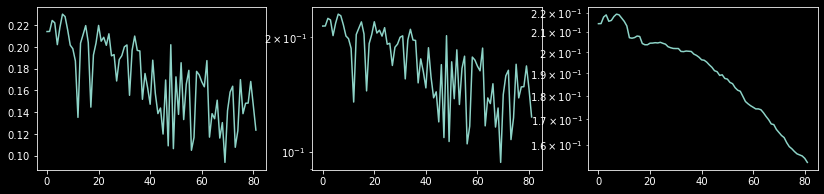

In [374]:
temp = np.array(train_loss)
avg = []
for _ in range(temp.size):
    t = np.mean(temp[max(_-50, 0):_+1])
    avg.append(t)
    
plt.figure(figsize=(14,3))
plt.subplot(1, 3, 1)
plt.plot(train_loss[0:])
plt.subplot(1, 3, 2)
plt.plot(train_loss[0:])
plt.semilogy()
plt.subplot(1, 3, 3)
plt.plot(avg[0:])
plt.semilogy()
plt.show()

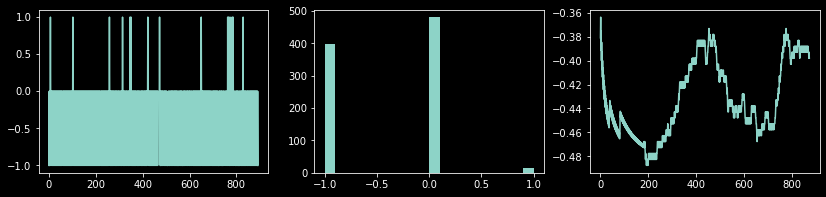

In [375]:
temp = np.array(WINS)
avg = []
for _ in range(temp.size):
    t = np.mean(temp[max(_-200, 0):_+1])
    avg.append(t) 

plt.figure(figsize=(14,3))
plt.subplot(1, 3, 1)
plt.plot(WINS)
plt.subplot(1, 3, 2)
plt.hist(WINS, bins=20)
plt.subplot(1, 3, 3)
plt.plot(avg[20:])
plt.show()

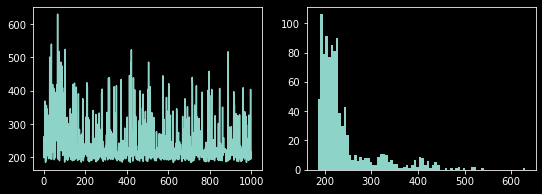

In [365]:
plt.figure(figsize=(9,3))
plt.subplot(1, 2, 1)
plt.plot(EPISODE_LENGTH)
plt.subplot(1, 2, 2)
plt.hist(EPISODE_LENGTH, bins=80)
plt.show()